If you are running this locally, please make sure you have Cuda Enabled, and Tensorflow 2.x and Pytorch 1.x installed with GPu support. 

You can also try this notebook on Google colab :
[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/IhabBendidi/sentiment_embeddings/blob/main/sentiment_embeddings.ipynb)

Whether locally or on Colab, if it's the first time running this notebook, run the following command to install all necessary dependencies (Pytorch and Tensorflow must be installed manually).

In [ ]:
!pip3 install -r requirements.txt

# Sentiment Analysis performance benchmark

**Authors :** *Ihab Bendidi*, *Yousra Bourkiche*, *Clément Siegrist*, *Kaouter Berrahal* 

In general, documents with similar sentiments, would be close to each other in the embeddings feature space. This can become another method to judge the performance of sentiment analysis models.

In this work, we aim to perform a benchmark of recent sentiment analysis works and models, reproduce their results, and judge their performance in comparison to baseline methods.

This work has the following plan :

**I - Processing & Exploratory Data Analysis**
- *Understanding the data*
- *Text Preprocessing*

**II - Sentiment classification models**
- *Bert Model*
- *LSTM recurrent model*

Throughout this project, we are working with a clean Ubuntu 20.04 distribution, on Python 3.7. We are going to use libraries such as Pytorch 1.8 and Tensorflow 2, which would be using GPU. For installation of dependencis, you can install them using the `requirements.txt` file. More details can be found in the `README.md` file. You can find below the specs of the GPU we have been using for our experiments.

In [2]:
!nvidia-smi

Wed Dec  9 00:28:03 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 455.45.01    Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   55C    P8    11W /  70W |      0MiB / 15079MiB |      0%      Default |
|                               |                      |                 ERR! |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

### *Abstract*

Lorem Ipsum

In [5]:
import transformers
from transformers import BertModel, BertTokenizer, AdamW, get_linear_schedule_with_warmup
import torch

import numpy as np
import pandas as pd
import seaborn as sns
from pylab import rcParams
import matplotlib.pyplot as plt
from matplotlib import rc
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report,precision_score
from collections import defaultdict
from textwrap import wrap

from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential, Model, load_model
from keras.layers import Dense, Embedding, LSTM, SpatialDropout1D,Input
from keras.optimizers import Adam
from keras import backend as K
from keras.callbacks import ModelCheckpoint


from torch import nn, optim
from torch.utils.data import Dataset, DataLoader
import torch.nn.functional as F

import warnings
warnings.filterwarnings('ignore')

%matplotlib inline
%config InlineBackend.figure_format='retina'

sns.set(style='whitegrid', palette='muted', font_scale=1.2)

HAPPY_COLORS_PALETTE = ["#01BEFE", "#FFDD00", "#FF7D00", "#FF006D", "#ADFF02", "#8F00FF"]

sns.set_palette(sns.color_palette(HAPPY_COLORS_PALETTE))

rcParams['figure.figsize'] = 12, 8

RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)
torch.manual_seed(RANDOM_SEED)

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device

device(type='cuda', index=0)

### I - Processing & Exploratory Data Analysis



#### 1 - Understanding the data

We would be working throughout this experiment on a Twitter dataset of complains and reviews of people about airline companies. These reviews got a sentiment already labelled, even though its apparent it was also generated with another model. This might incur incorrect labels, but as long as the models we use are trained on the same dataset, it would still fit our comparison purpose, even though it won't have much use in production. While this dataset is limiting, especially in terms of size, it would also be a good baseline to start our work with.

We import out dataset in the form of a `.csv` file to put it in a Pandas Dataframe.

In [6]:
df = pd.read_csv('tweets.csv')

In [7]:
# The size of our dataset
df.shape

(14640, 15)

As we explore the values of our dataset, we notice that much of the data is not pertinent for our task. As most of the data is for airlines to know the general opinions about their services. The most interesting columns for us are `airline_sentiment`, and the `text` columns.

In [8]:
# Show the first five values of our dataframe
df.head()

,tweet_id,airline_sentiment,airline_sentiment_confidence,negativereason,negativereason_confidence,airline,airline_sentiment_gold,name,negativereason_gold,retweet_count,text,tweet_coord,tweet_created,tweet_location,user_timezone
0,570306133677760513,neutral,1.0000,NaN,NaN,Virgin America,NaN,cairdin,NaN,0,@VirginAmerica What @dhepburn said.,NaN,2015-02-24 11:35:52 -0800,NaN,Eastern Time (US & Canada)
1,570301130888122368,positive,0.3486,NaN,0.0000,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica plus you've added commercials t...,NaN,2015-02-24 11:15:59 -0800,NaN,Pacific Time (US & Canada)
2,570301083672813571,neutral,0.6837,NaN,NaN,Virgin America,NaN,yvonnalynn,NaN,0,@VirginAmerica I didn't today... Must mean I n...,NaN,2015-02-24 11:15:48 -0800,Lets Play,Central Time (US & Canada)
3,570301031407624196,negative,1.0000,Bad Flight,0.7033,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica it's really aggressive to blast...,NaN,2015-02-24 11:15:36 -0800,NaN,Pacific Time (US & Canada)
4,570300817074462722,negative,1.0000,Can't Tell,1.0000,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica and it's a really big bad thing...,NaN,2015-02-24 11:14:45 -0800,NaN,Pacific Time (US & Canada)


In [9]:
# importing the interesting & pertinent data in our dataset into a new dataframe
tweets = df[['tweet_id','text','airline_sentiment','airline_sentiment_confidence']]
tweets.head()

,tweet_id,text,airline_sentiment,airline_sentiment_confidence
0,570306133677760513,@VirginAmerica What @dhepburn said.,neutral,1.0000
1,570301130888122368,@VirginAmerica plus you've added commercials t...,positive,0.3486
2,570301083672813571,@VirginAmerica I didn't today... Must mean I n...,neutral,0.6837
3,570301031407624196,@VirginAmerica it's really aggressive to blast...,negative,1.0000
4,570300817074462722,@VirginAmerica and it's a really big bad thing...,negative,1.0000


To explore our data further, it is a must to check whether there are missing values. Though as seen below, it appears there is none in the data that matters.

In [10]:
# The count of null or nan values in the dataset
tweets.isnull().sum()

tweet_id                        0
text                            0
airline_sentiment               0
airline_sentiment_confidence    0
dtype: int64

Our next focus would be to know the existing categories in the sentiment labels in `airline_sentiment`. We would then create a plot of their occurence in our data.

In [11]:
# Unique values in a Series of the dataframe
tweets['airline_sentiment'].unique()

array(['neutral', 'positive', 'negative'], dtype=object)

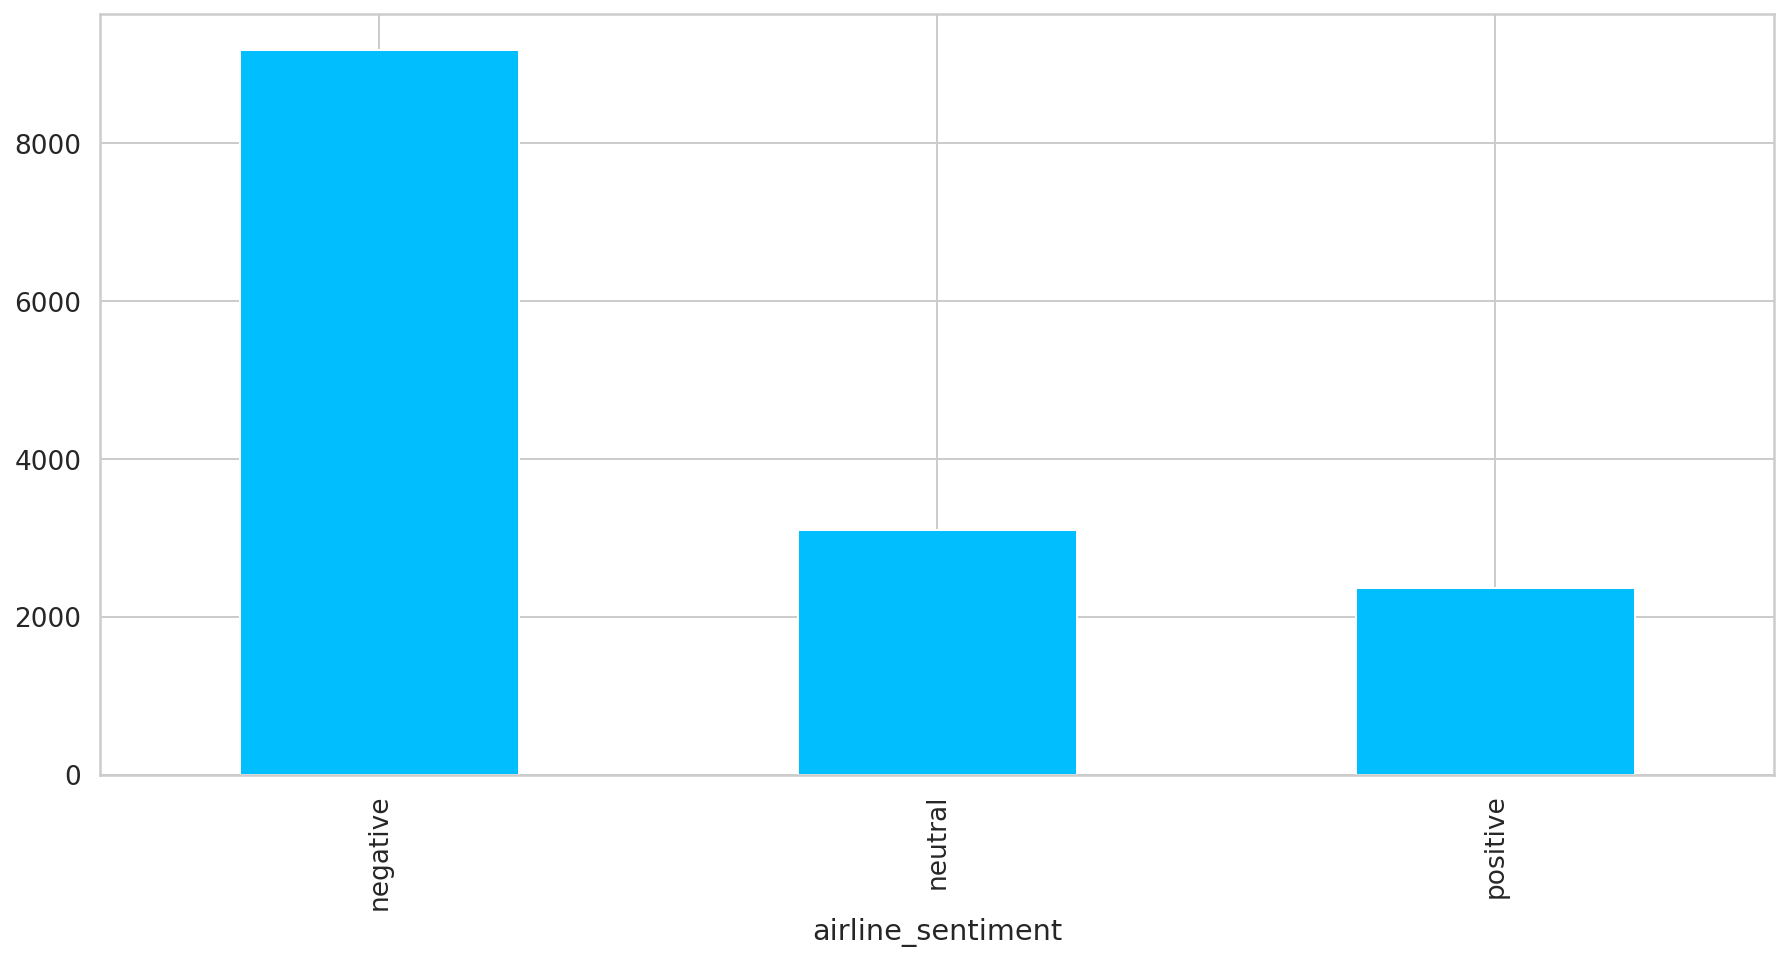

In [12]:
tweets.groupby('airline_sentiment')['tweet_id'].count().plot.bar(figsize=(15,7),grid=True)

As it appears, our data is heavily imbalanced, as the `negative` category got up three times more occurences than the `neutral` or `positive` category. This is a matter that would need to be taken into account when judging the model performance, to avoid any bias in its predictions.

On another note, we take a peak at the format of the tweets and texts we'll be handling below.

In [13]:
print(tweets['text'][1000])

@united how can you not put my bag on plane to Seattle. Flight 1212. Waiting  in line to talk to someone about my bag. Status should matter.


#### 2 - Text preprocessing

In this part, we'll be handling the text data, cleaning it from discrepancies, and preparing it to be in a format that is friendly to processing by our models, that would come further on the line.

We can notice in the following tweets, and through other careful explorations of the dataset, that airline company names are often tagged at the beginning of every tweet.

In [14]:
print(tweets['text'][10])
print(tweets['text'][1000])

@VirginAmerica did you know that suicide is the second leading cause of death among teens 10-24
@united how can you not put my bag on plane to Seattle. Flight 1212. Waiting  in line to talk to someone about my bag. Status should matter.


While this appears harmless, we could also forward a hypothesis that our models, further down the line, might overfit and learn to map company names tagged in the tweet directly to a sentiment category. That would be especially possible of some company names got some specific categories of sentiment review much more often than others.

To make certain of whether this hypothesis is unfounded or not, we search here for the occurences of the different categories of sentiments for each company name tagged.

To achieve that, we start by extracting the tags from every tweet.

In [15]:
# This helper function returns the tags appearing mostly at the beginning of each tweet
def get_tags(row):
    splits = row['text'].split(' ')
    # Some simple text processing to have all tags in the same format
    row['tags'] = ''.join(e for e in splits[0] if e.isalnum()).lower()   
    # Correcting a very common typo
    if row['tags'] == 'jetblue':
        row['tags'] = 'jetblues'
    return row

# Extracting the tags (without deletion) from the tweets into their own columns
df = tweets.apply(get_tags,axis=1)

Our dataframe has a new Series inside, of the tags of the companies occuring in the tweets, in an unified format.

In [16]:
df.head()

,tweet_id,text,airline_sentiment,airline_sentiment_confidence,tags
0,570306133677760513,@VirginAmerica What @dhepburn said.,neutral,1.0000,virginamerica
1,570301130888122368,@VirginAmerica plus you've added commercials t...,positive,0.3486,virginamerica
2,570301083672813571,@VirginAmerica I didn't today... Must mean I n...,neutral,0.6837,virginamerica
3,570301031407624196,@VirginAmerica it's really aggressive to blast...,negative,1.0000,virginamerica
4,570300817074462722,@VirginAmerica and it's a really big bad thing...,negative,1.0000,virginamerica


Our next task would be to group the tags and sentiment categories together, to be able to count the occurences of each category in each tag.

In [17]:
# Defining a helper function to count the occurences of each category of sentiment for each tag
def count_tags(df, col, new_col):
    df[new_col] = df[col].count()
    return df

# Grouping all tags and sentiment categories together, in order to count occurences of categories 
# of sentiments for each category, then saving the resulting Series into our DataFrame
df['tag_count'] = df.groupby(['tags','airline_sentiment']).apply(count_tags,'tweet_id','count')['count']

While this would enable us to have the exact count of occurences of each category of sentiment for each tag, we would find that there is some noise in our data. We would be filtering that noise by only keeping the tags whose count is beyond 15. The number of the filtered tags is negligible.

In [18]:
temp_df = df[df['tag_count']>15].copy()

Following that, we create a cross table of the values of the count of occurences for each sentiment category, for each company tag, then we plot a bar plot to visualize the differences between the occurences.

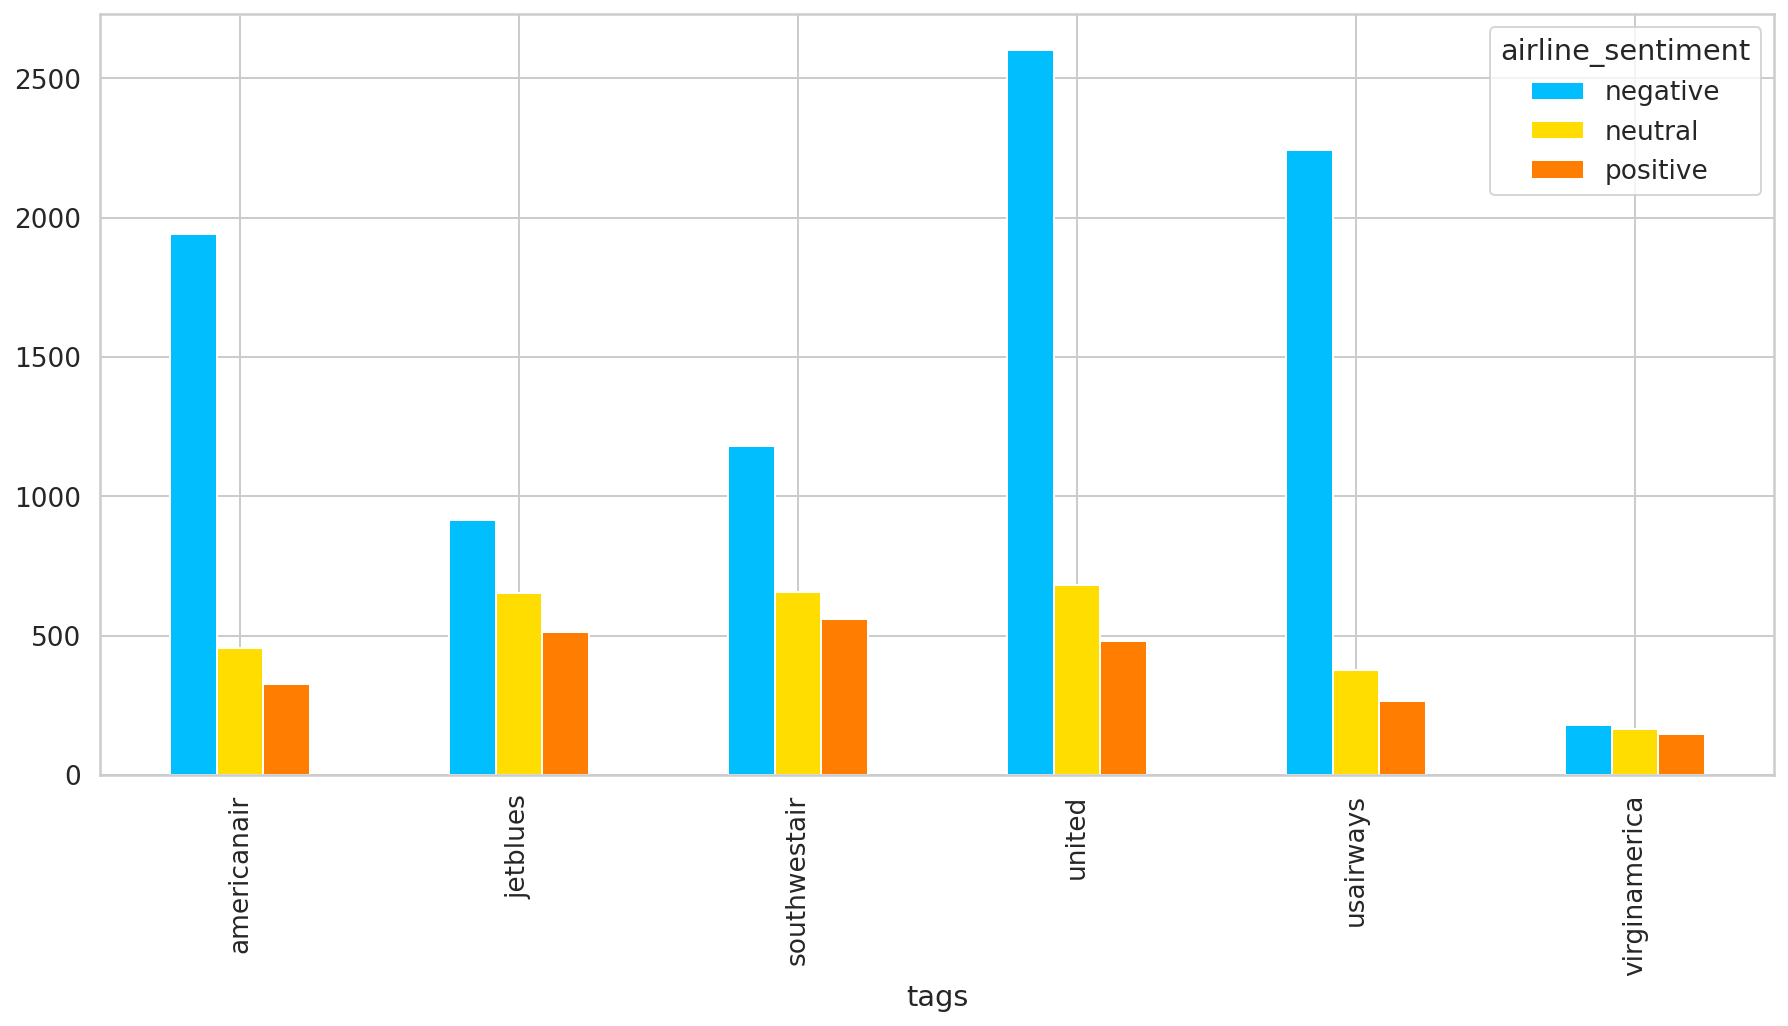

In [19]:
# Create a cross table of the count of the occurences of tags/sentiment classes
cross_df = pd.crosstab(temp_df.tags,temp_df.airline_sentiment,values=temp_df['tag_count'],
                       margins=False,aggfunc='mean')

# Visualize our results in a bar plot
cross_df.plot.bar(figsize=(15,7),grid=True)

The earlier results in the plot have proven our hypothesis right : Some company tags got a very large ratio of negative sentiments. We believe these tags might make the model learn to map the presence of the tags to a sentiment category, mostly the `negative` category, as it is the major category for the tags `americanair`, `united` and `usairways`.

Our next task would involve deleting them from our tweets, to handle the text without bias.

In [20]:
# A helper function that would remove the tags from the text and save it into a new column
def remove_tags(row):
    splits = row['text'].split(' ')
    row['review'] = ' '.join(splits[1:])
    return row

# Removing the tags from the text and saving the cleaned up text in a new column
tweets = df.apply(remove_tags,axis=1)[['tweet_id','text','review','airline_sentiment']]

tweets.head()

,tweet_id,text,review,airline_sentiment
0,570306133677760513,@VirginAmerica What @dhepburn said.,What @dhepburn said.,neutral
1,570301130888122368,@VirginAmerica plus you've added commercials t...,plus you've added commercials to the experienc...,positive
2,570301083672813571,@VirginAmerica I didn't today... Must mean I n...,I didn't today... Must mean I need to take ano...,neutral
3,570301031407624196,@VirginAmerica it's really aggressive to blast...,"it's really aggressive to blast obnoxious ""ent...",negative
4,570300817074462722,@VirginAmerica and it's a really big bad thing...,and it's a really big bad thing about it,negative


Before going further, we will encode our labels, the `airline_sentiment` categories, to make it easier to work on this classification task.

In [21]:
# Define a helper function for one hot encoding
def one_hot_encode(row):
    if row['airline_sentiment'] == "negative":
        row['target'] = 0
    if row['airline_sentiment'] == "neutral":
        row['target'] = 1
    if row['airline_sentiment'] == "positive":
        row['target'] = 2
    return row

# The class names : 0 -> negative, 1 -> neutral, 2 -> positive
class_names = ['negative', 'neutral', 'positive']

# One hot encode the labels of our dataset
tweets = tweets.apply(one_hot_encode,axis=1)[['review','target','tweet_id','text','airline_sentiment']]

tweets.head()

,review,target,tweet_id,text,airline_sentiment
0,What @dhepburn said.,1,570306133677760513,@VirginAmerica What @dhepburn said.,neutral
1,plus you've added commercials to the experienc...,2,570301130888122368,@VirginAmerica plus you've added commercials t...,positive
2,I didn't today... Must mean I need to take ano...,1,570301083672813571,@VirginAmerica I didn't today... Must mean I n...,neutral
3,"it's really aggressive to blast obnoxious ""ent...",0,570301031407624196,@VirginAmerica it's really aggressive to blast...,negative
4,and it's a really big bad thing about it,0,570300817074462722,@VirginAmerica and it's a really big bad thing...,negative


Our following goal would be to preprocess further our text data for NLP. One of the models we would be working is BERT. BERT (introduced in [this paper](https://arxiv.org/abs/1810.04805)) stands for Bidirectional Encoder Representations from Transformers.

Machine Learning models don't work with raw text. You need to convert text to numbers (of some sort). BERT requires even more attention. Here are the requirements:

- Add special tokens to separate sentences and do classification
- Pass sequences of constant length (introduce padding)
- Create array of 0s (pad token) and 1s (real token) called attention mask

We can use a cased and uncased version of BERT and tokenizer. Intuitively, the cased version would work better, since "BAD" might convey more sentiment than "bad".

Different from classical text processing, which we would perform on the text data for another model later on, we would be using a a pre-trained [BertTokenizer](https://huggingface.co/transformers/model_doc/bert.html#berttokenizer):


In [22]:
PRE_TRAINED_MODEL_NAME = 'bert-base-cased'
tokenizer = BertTokenizer.from_pretrained(PRE_TRAINED_MODEL_NAME)

BERT works with fixed-length sequences. We'll use a simple strategy to choose the max length, so that we pad each token until it achieves the max length. Let's store the token length of each text :

Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.


Text(0.5, 0, 'Token count')

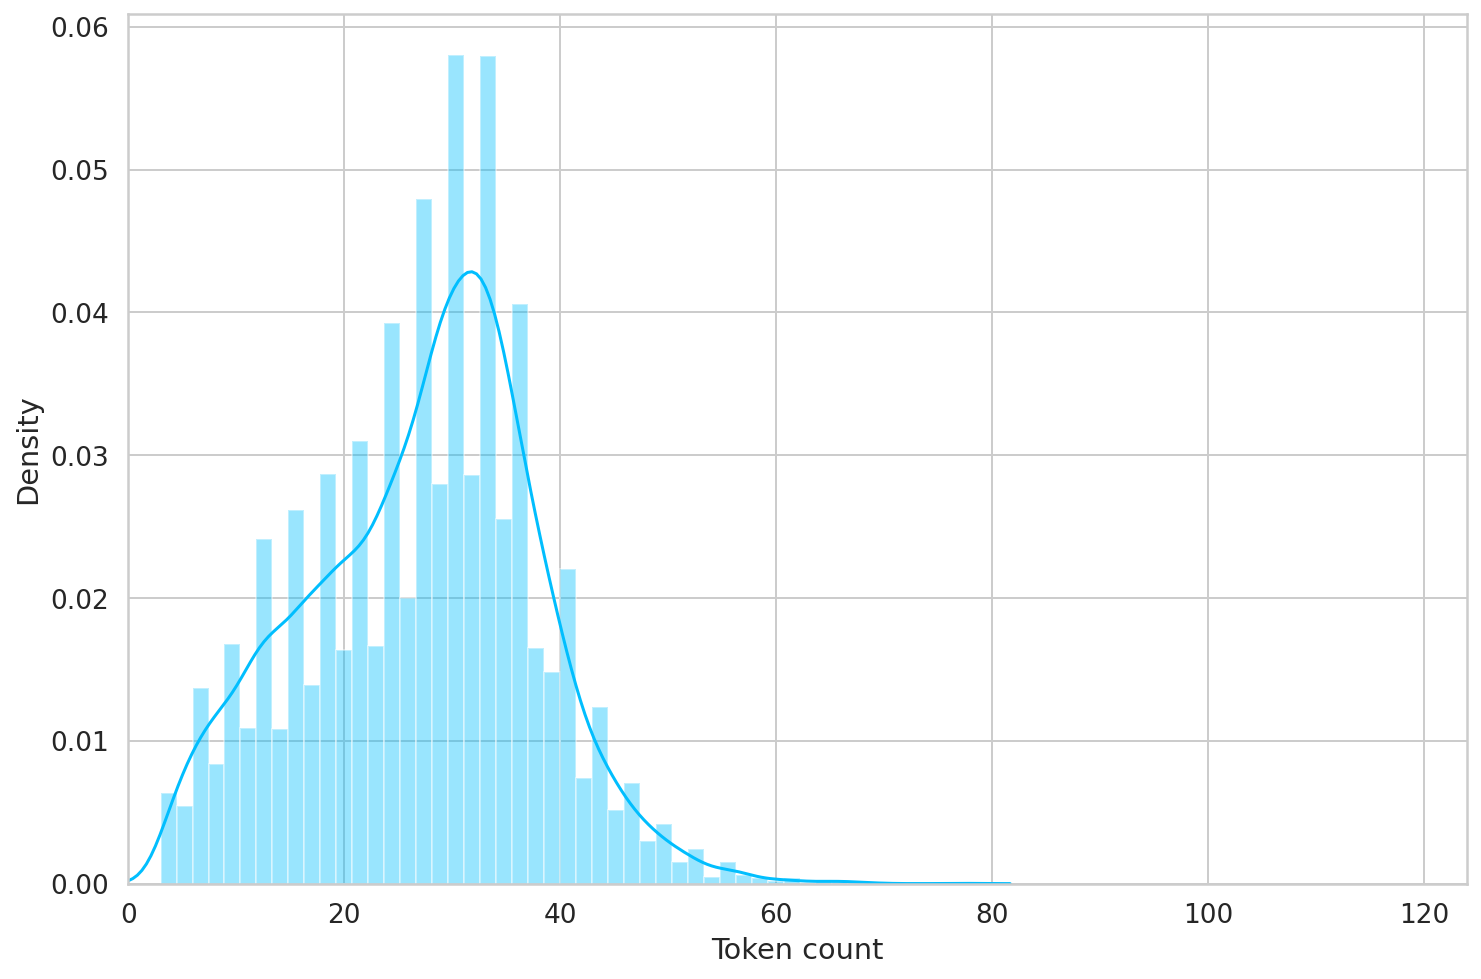

In [23]:
# List of the length of each generated token
token_lens = []

# Storing the length of the token of each text in our dataset
for txt in tweets.review:
    tokens = tokenizer.encode(txt, max_length=512)
    token_lens.append(len(tokens))
    
# Plotting the distribution of the lengths of the tokens in our dataset
sns.distplot(token_lens)
plt.xlim([0, 124])
plt.xlabel('Token count')

Most of the texts contain between 20 and 40 token, but to stay on the safe side, we'll take a maximum length of 70 token.

In [24]:
MAX_LEN = 70

Our following task is to manipulate our dataset to make it into a Pytorch dataset, that would make it simple to work on it to train our BERT model later on.

In [25]:
class GPReviewDataset(Dataset):
    def __init__(self, reviews, targets, tokenizer, max_len):
        self.reviews = reviews
        self.targets = targets
        self.tokenizer = tokenizer
        self.max_len = max_len
  
    def __len__(self):
        return len(self.reviews)
  
    def __getitem__(self, item):
        review = str(self.reviews[item])
        target = self.targets[item]
        
        # Tokenizing the texts, while also including special tokens 
        # for start and end of the text, as well as padding
        encoding = self.tokenizer.encode_plus(
          review,
          add_special_tokens=True,
          max_length=self.max_len,
          return_token_type_ids=False,
          pad_to_max_length=True,
          return_attention_mask=True,
          return_tensors='pt', # We return here the data as Pytorch Tensor
        )

        return {
          'review_text': review,
          'input_ids': encoding['input_ids'].flatten(),
          'attention_mask': encoding['attention_mask'].flatten(),
          'targets': torch.tensor(target, dtype=torch.long)
        }

The tokenizer is doing most of the heavy lifting for us. We also return the review texts, so it'll be easier to evaluate the predictions from our model. Let's split the data, with 70% training, 10% validation set, and 20% test set :

In [26]:
# Splitting the test data 
df_temp, df_test = train_test_split(tweets, test_size=0.2, random_state=RANDOM_SEED)

# Splitting the training and validation data
df_train, df_val = train_test_split(df_temp, test_size=0.1, random_state=RANDOM_SEED)

print("The size of training set is : " + str(df_train.shape[0]))
print("The size of validation set is : " + str(df_val.shape[0]))
print("The size of test set is : " + str(df_test.shape[0]))

The size of training set is : 10540
The size of validation set is : 1172
The size of test set is : 2928


We also need to create a couple of data loaders for Pytorch :

In [27]:
def create_data_loader(df, tokenizer, max_len, batch_size):
    ds = GPReviewDataset(
        reviews=df.review.to_numpy(),
        targets=df.target.to_numpy(),
        tokenizer=tokenizer,
        max_len=max_len
      )

    return DataLoader(
        ds,
        batch_size=batch_size,
        num_workers=4
      )


BATCH_SIZE = 16

train_data_loader = create_data_loader(df_train, tokenizer, MAX_LEN, BATCH_SIZE)
val_data_loader = create_data_loader(df_val, tokenizer, MAX_LEN, BATCH_SIZE)
test_data_loader = create_data_loader(df_test, tokenizer, MAX_LEN, BATCH_SIZE)



A simple exploration of an example batch of our data loader would show the following :

In [28]:
# Loading a batch of 16 observation from the training set, tokenized and processed
data = next(iter(train_data_loader))
print(data.keys())

dict_keys(['review_text', 'input_ids', 'attention_mask', 'targets'])


In [29]:
# For each batch of 16 observations
print(data['input_ids'].shape)
print(data['attention_mask'].shape)
print(data['targets'].shape)

torch.Size([16, 70])
torch.Size([16, 70])
torch.Size([16])


### II - Sentiment classification models


#### 1 - Bert Model

In this step, we'll be using a basic pretrained Bert Model, and build our sentiment classifier on top of it. We'll be importing it as follow :

In [28]:
# When first executing this, it would take time to download the model from web if it doesn't exist locally
# Make sure to have your internet activated the first time you run this cell locally
bert_model = BertModel.from_pretrained(PRE_TRAINED_MODEL_NAME)

We would need to add classification layers at the top of our BERT model. But to do that, we would need to know the sizes of its current outputs. We can do that by testing it on the earlier batch of data :

In [29]:
# Making test predictions using the raw BERT model on the batch data we made earlier
model_outs = bert_model(
  input_ids=data['input_ids'], 
  attention_mask=data['attention_mask']
)

# The last hidden layer in the raw BERT model
last_hidden_state = model_outs[0]
pooled_output = model_outs[1]

In [30]:
last_hidden_state.shape

torch.Size([16, 70, 768])

We have the hidden state for each of our 70 tokens (the length of our example sequence). 768 is the number of hidden units in the feedforward-networks. 

We can now use this knowledge to create a classifier that uses the BERT model.

In [31]:
# Defining our classifier that we would build on top of the raw bert model
class SentimentClassifier(nn.Module):

    def __init__(self, n_classes):
        super(SentimentClassifier, self).__init__()
        self.bert = BertModel.from_pretrained(PRE_TRAINED_MODEL_NAME)
        # Adding drop out, keeping 70% of the last neurons of the raw BERT model
        self.drop = nn.Dropout(p=0.3)
        # The last linear layer for multiclass classification
        self.out = nn.Linear(self.bert.config.hidden_size, n_classes)
  
    # Forward propagation function
    def forward(self, input_ids, attention_mask):
        model_outs = self.bert(
          input_ids=input_ids,
          attention_mask=attention_mask
        )
        last_hidden_state = model_outs[0]
        pooled_output = model_outs[1]
        output = self.drop(pooled_output)
        return self.out(output)

Our classifier delegates most of the heavy lifting to the BertModel. We use a dropout layer for some regularization and a fully-connected layer for our output. We're returning the raw output of the last layer since that is required for the cross-entropy loss function in PyTorch to work.

We now pass the instance of our classifier to GPU :


In [32]:
# Initializing the classifier to output three class categories
model = SentimentClassifier(len(class_names))

# Running the classifier on GPU
model = model.to(device)

Similarly, we'll move the example batch of our training data to the GPU:

In [33]:
# Saving the input data on GPU
input_ids = data['input_ids'].to(device)
attention_mask = data['attention_mask'].to(device)

print(input_ids.shape) # batch size x seq length
print(attention_mask.shape) # batch size x seq length

torch.Size([16, 70])
torch.Size([16, 70])


To get the predicted probabilities from our trained model, we'll apply the softmax function to the outputs:

In [34]:
F.softmax(model(input_ids, attention_mask), dim=1)

tensor([[0.4191, 0.1861, 0.3947],
        [0.5449, 0.1308, 0.3243],
        [0.2789, 0.1379, 0.5832],
        [0.5505, 0.1105, 0.3390],
        [0.5695, 0.1898, 0.2407],
        [0.3330, 0.1613, 0.5057],
        [0.4120, 0.0986, 0.4894],
        [0.2955, 0.2547, 0.4498],
        [0.3355, 0.1382, 0.5263],
        [0.2590, 0.2234, 0.5176],
        [0.3927, 0.1524, 0.4549],
        [0.4370, 0.1933, 0.3697],
        [0.5702, 0.0900, 0.3397],
        [0.4757, 0.1866, 0.3377],
        [0.3993, 0.1894, 0.4113],
        [0.3546, 0.1869, 0.4585]], device='cuda:0', grad_fn=<SoftmaxBackward>)

Following that, to reproduce the training procedure from the BERT paper, we'll use the [AdamW](https://huggingface.co/transformers/main_classes/optimizer_schedules.html#adamw) optimizer provided by Hugging Face. It corrects weight decay, so it's similar to the original paper. We'll also use a linear scheduler with no warmup steps:

In [35]:
# Number of epochs for training
EPOCHS = 10

# Adam optimizer
optimizer = AdamW(model.parameters(), lr=2e-5, correct_bias=False)
total_steps = len(train_data_loader) * EPOCHS

scheduler = get_linear_schedule_with_warmup(
  optimizer,
  num_warmup_steps=0,
  num_training_steps=total_steps
)

# Cross Entropy Loss Function
loss_fn = nn.CrossEntropyLoss().to(device)

The BERT authors have some recommendations for fine-tuning:

- Batch size: 16, 32
- Learning rate (Adam): 5e-5, 3e-5, 2e-5
- Number of epochs: 2, 3, 4

We're going to ignore the number of epochs recommendation but stick with the rest. Note that increasing the batch size reduces the training time significantly, but gives you lower accuracy.

We'll begin with writing a helper function for computing the precision of our model for each epoch, by computing the precision for each class, while taking label imbalance into account, and computing the weighted average precision, mode details [here](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.precision_score.html) :

In [36]:
# Computing multiclass precision for the outputs of the model
def compute_precision(outputs, labels):
  op = outputs.cpu()
  la = labels.cpu()
  _, preds = torch.max(op, dim=1)
  # We choose 'weighted' averaging of the precision of each label because it takes into account the imbalance of labels in our tweets dataset
  # other viable averaging methods are 'micro'
  return torch.tensor(precision_score(la,preds, average='weighted')) 

Let's continue with writing a helper function for training our model for one epoch:

In [37]:
def train_epoch(
  model, 
  data_loader, 
  loss_fn, 
  optimizer, 
  device, 
  scheduler, 
  n_examples
):
    model = model.train()

    losses = []
    correct_predictions = 0
    precision = 0
    i = 0
  
    for d in data_loader: # d is our batch of observations
        i += 1

        #preparing inputs
        input_ids = d["input_ids"].to(device)
        attention_mask = d["attention_mask"].to(device)
        targets = d["targets"].to(device)

        # Running inference
        outputs = model(
          input_ids=input_ids,
          attention_mask=attention_mask
        )
        
        # softmax on the outputs to get the classes
        _, preds = torch.max(outputs, dim=1)

        # Computing loss
        loss = loss_fn(outputs, targets)

        # Counting the correct occurences
        correct_predictions += torch.sum(preds == targets)

        losses.append(loss.item())

        # Computing the precision (true positives/true positives + false positives) 
        # for each class and label, and find their average weighted by support 
        precision += compute_precision(outputs,targets)
        
        # Backward propagation
        loss.backward()
        nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        optimizer.step()
        scheduler.step()
        optimizer.zero_grad()

    return correct_predictions.double() / n_examples, np.mean(losses), precision/i # Accuracy, loss, precision

The scheduler gets called every time a batch is fed to the model. We're avoiding exploding gradients by clipping the gradients of the model using [clip_grad_norm_](https://pytorch.org/docs/stable/nn.html#clip-grad-norm).

We'll then write another helper function that helps us evaluate the model on a given data loader:

In [38]:
def eval_model(model, data_loader, loss_fn, device, n_examples):
    model = model.eval()

    losses = []
    correct_predictions = 0
    precision = 0
    i = 0

    with torch.no_grad():
        for d in data_loader:
            i += 1

            # Preparing inputs
            input_ids = d["input_ids"].to(device)
            attention_mask = d["attention_mask"].to(device)
            targets = d["targets"].to(device)

            # Running inference using the model
            outputs = model(
                input_ids=input_ids,
                attention_mask=attention_mask
              )
            
            # Running softmax on the outputs
            _, preds = torch.max(outputs, dim=1)

            # Computing loss function
            loss = loss_fn(outputs, targets)

            # Counting the correct occurences
            correct_predictions += torch.sum(preds == targets)

            # Computing the precision (true positives/true positives + false positives) 
            # for each class and label, and find their average weighted by support 
            precision += compute_precision(outputs,targets)

            losses.append(loss.item())

    return correct_predictions.double() / n_examples, np.mean(losses), precision/i # Accuracy, loss, precision

Using those two, we can write our training loop. We'll also store the training history:

In [39]:
%%time

# creating history object, to keep history of results
history = defaultdict(list)
best_accuracy = 0

# Iterating on epochs
for epoch in range(EPOCHS):

    print(f'Epoch {epoch + 1}/{EPOCHS}')
    print('-' * 10)

    # Running the training on the whole dataset (divided into batches)
    train_acc, train_loss, train_precision = train_epoch(
        model,
        train_data_loader,    
        loss_fn, 
        optimizer, 
        device, 
        scheduler, 
        len(df_train)
      )

    # Results of training
    print(f'Train : loss {train_loss}, accuracy {train_acc}, precision {train_precision}')

    # Running the validation on the whole dataset (divided into batches)
    val_acc, val_loss, val_precision = eval_model(
        model,
        val_data_loader,
        loss_fn, 
        device, 
        len(df_val)
      )

    # Results of validation
    print(f'Val : loss {val_loss}, accuracy {val_acc}, precision {val_precision}')
    print()

    # Keeping all results into history
    history['train_acc'].append(train_acc)
    history['train_loss'].append(train_loss)
    history['train_precision'].append(train_precision)
    history['val_acc'].append(val_acc)
    history['val_loss'].append(val_loss)
    history['val_precision'].append(val_precision)

    # Saving the model with the best accuracy
    if val_acc > best_accuracy:
        torch.save(model.state_dict(), 'best_model_state.bin')
        best_accuracy = val_acc

Epoch 1/10
----------
Train : loss 0.5336638307410867, accuracy 0.7937381404174573, precision 0.8128075415774574
Val : loss 0.5097645931449291, accuracy 0.8225255972696246, precision 0.8327996585809085

Epoch 2/10
----------
Train : loss 0.28815961526127387, accuracy 0.8996204933586338, precision 0.9180582505506636
Val : loss 0.5173394468839507, accuracy 0.840443686006826, precision 0.8561103404853408

Epoch 3/10
----------
Train : loss 0.16401975514467562, accuracy 0.9564516129032258, precision 0.9654173358886948
Val : loss 0.7103318145272095, accuracy 0.8421501706484642, precision 0.8633779977529982

Epoch 4/10
----------
Train : loss 0.09937565966243594, accuracy 0.9759962049335863, precision 0.9819180361242204
Val : loss 0.8404175414030466, accuracy 0.8378839590443686, precision 0.8533704705579709

Epoch 5/10
----------
Train : loss 0.06870397610728712, accuracy 0.9840607210626185, precision 0.9883391456798138
Val : loss 0.9713083968113957, accuracy 0.8310580204778157, precision 0.

Note that we're storing the state of the best model, indicated by the highest validation accuracy. The results would take some time. With our GPU, it took around 1 hour.

The following shows the result of the changes in accuracy and precision across epochs :


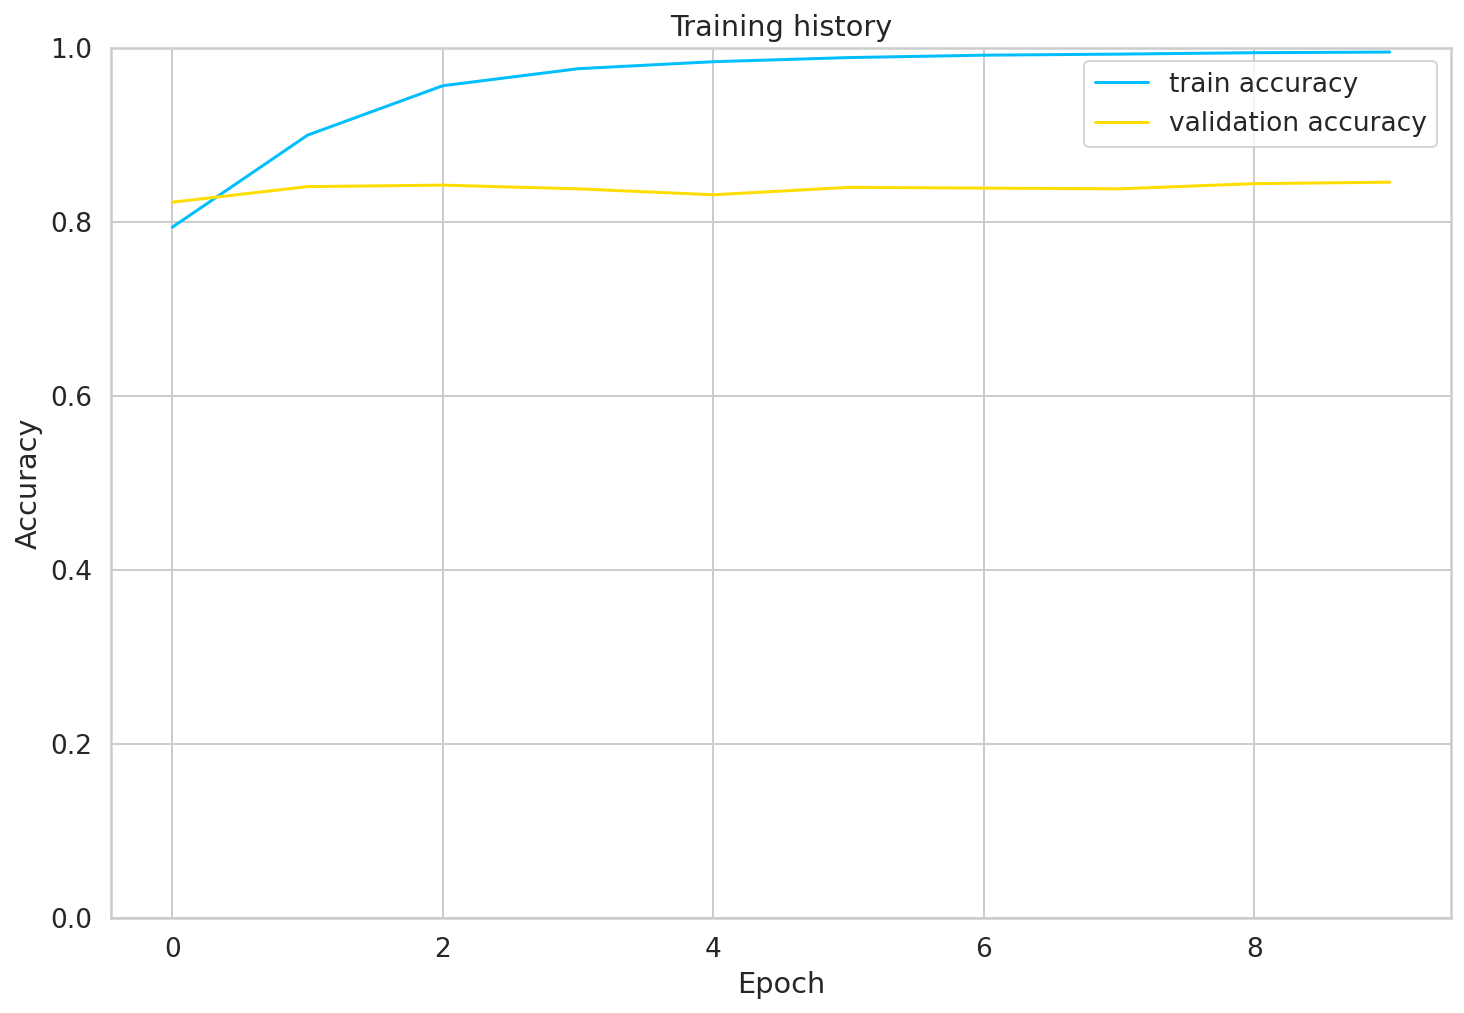

In [40]:
# Plotting the results of the training and validation accuracy using the stored information in history
plt.plot(history['train_acc'], label='train accuracy')
plt.plot(history['val_acc'], label='validation accuracy')

plt.title('Training history')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend()
plt.ylim([0, 1]);

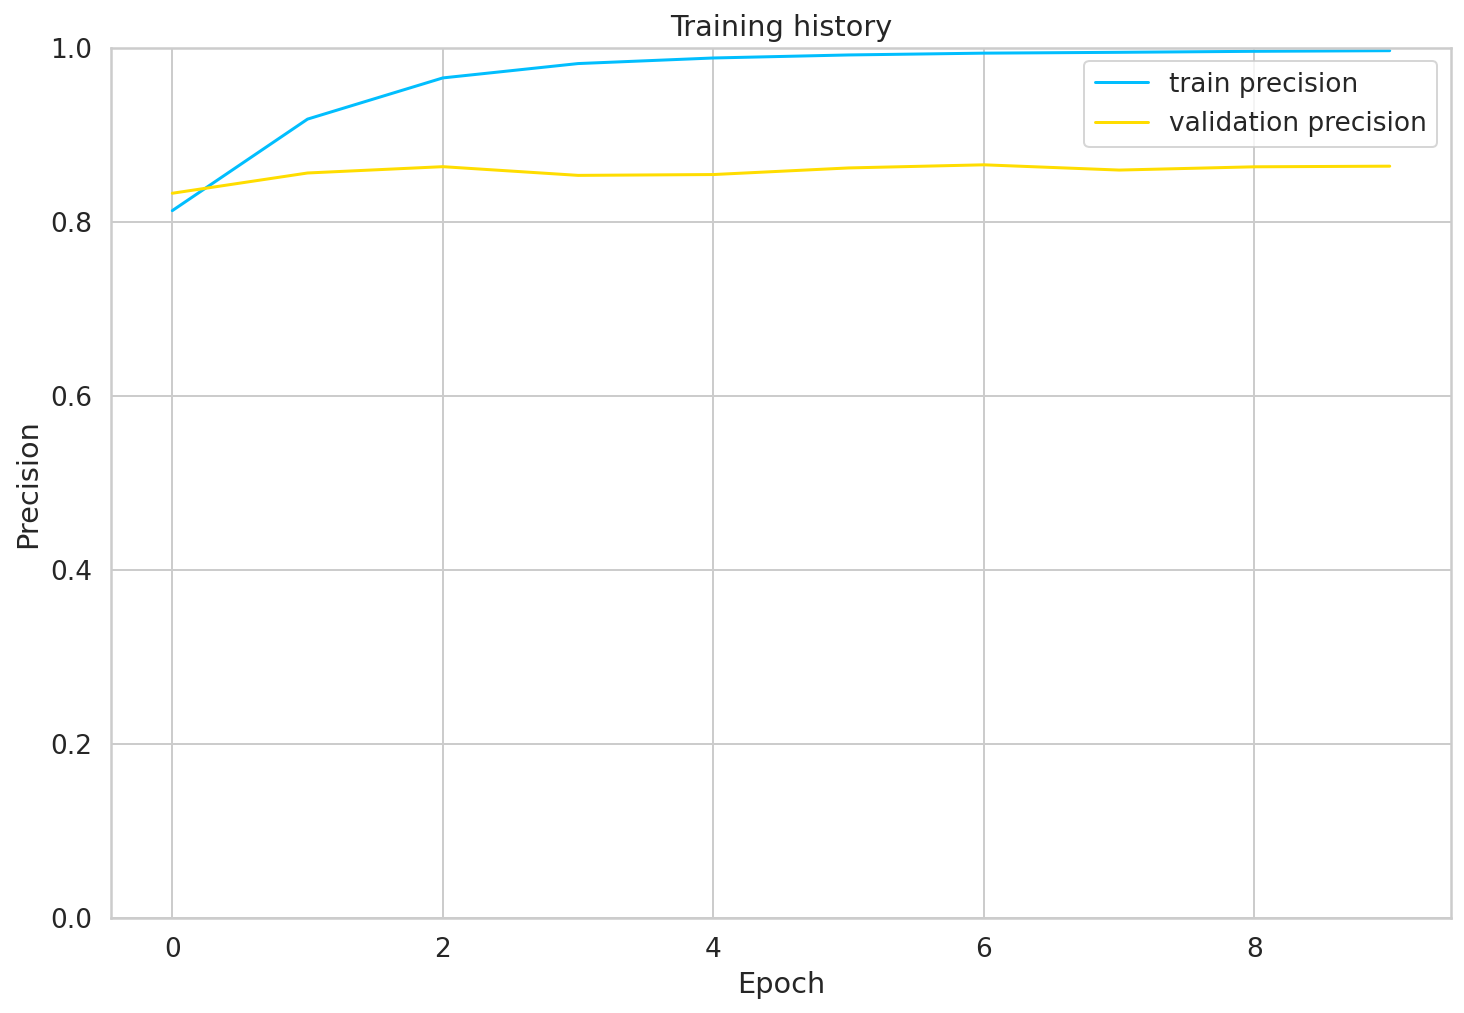

In [41]:
# Plotting the results of the training and validation precision using the stored information in history
plt.plot(history['train_precision'], label='train precision')
plt.plot(history['val_precision'], label='validation precision')

plt.title('Training history')
plt.ylabel('Precision')
plt.xlabel('Epoch')
plt.legend()
plt.ylim([0, 1]);

We read the best model of our training and store it into gpu for future usage :

In [42]:
model = SentimentClassifier(len(class_names))
model.load_state_dict(torch.load('best_model_state.bin'))
model = model.to(device)

To get a good glimpse on how good our model is at predicting sentiment, we'll compute accuracu on the test data :

In [43]:
test_acc, _, _ = eval_model(
  model,
  test_data_loader,
  loss_fn,
  device,
  len(df_test)
)

test_acc.item()

0.8415300546448088

The accuracy is about the same on the test set than on validation set. Our model seems to generalize well.

We'll define a helper function to get the predictions from our model:

In [44]:
def get_predictions(model, data_loader):
  model = model.eval()
  
  review_texts = []
  predictions = []
  prediction_probs = []
  real_values = []

  with torch.no_grad():
    for d in data_loader:

      texts = d["review_text"]
      input_ids = d["input_ids"].to(device)
      attention_mask = d["attention_mask"].to(device)
      targets = d["targets"].to(device)

      outputs = model(
        input_ids=input_ids,
        attention_mask=attention_mask
      )
      _, preds = torch.max(outputs, dim=1)

      probs = F.softmax(outputs, dim=1)

      review_texts.extend(texts)
      predictions.extend(preds)
      prediction_probs.extend(probs)
      real_values.extend(targets)

  predictions = torch.stack(predictions).cpu()
  prediction_probs = torch.stack(prediction_probs).cpu()
  real_values = torch.stack(real_values).cpu()
  return review_texts, predictions, prediction_probs, real_values

This is similar to the evaluation function, except that we're storing the text of the reviews and the predicted probabilities (by applying the softmax on the model outputs):

In [45]:
y_review_texts, y_pred, y_pred_probs, y_test = get_predictions(
  model,
  test_data_loader
)

Let's have a look at the classification report :

In [46]:
print(classification_report(y_test, y_pred, target_names=class_names))

              precision    recall  f1-score   support

    negative       0.90      0.92      0.91      1889
     neutral       0.69      0.62      0.66       580
    positive       0.77      0.79      0.78       459

    accuracy                           0.84      2928
   macro avg       0.79      0.78      0.78      2928
weighted avg       0.84      0.84      0.84      2928



Looks like it is really hard to classify neutral reviews. Even empirically, looking at many reviews, those are hard to classify.

We also observe very good results on the negative class, which understandable, knowing it to be the major class in our dataset with the most occurences.

Using the `weighted` average that takes into account the imbalances in the dataset and tries to correct them, we observe very good results in precision, recall and f1-score. Even in `macro` averaging, where we don't try to correct imbalances in the dataset, we still keep having good average precision, recall and f1-score.

We'll continue with the confusion matrix:

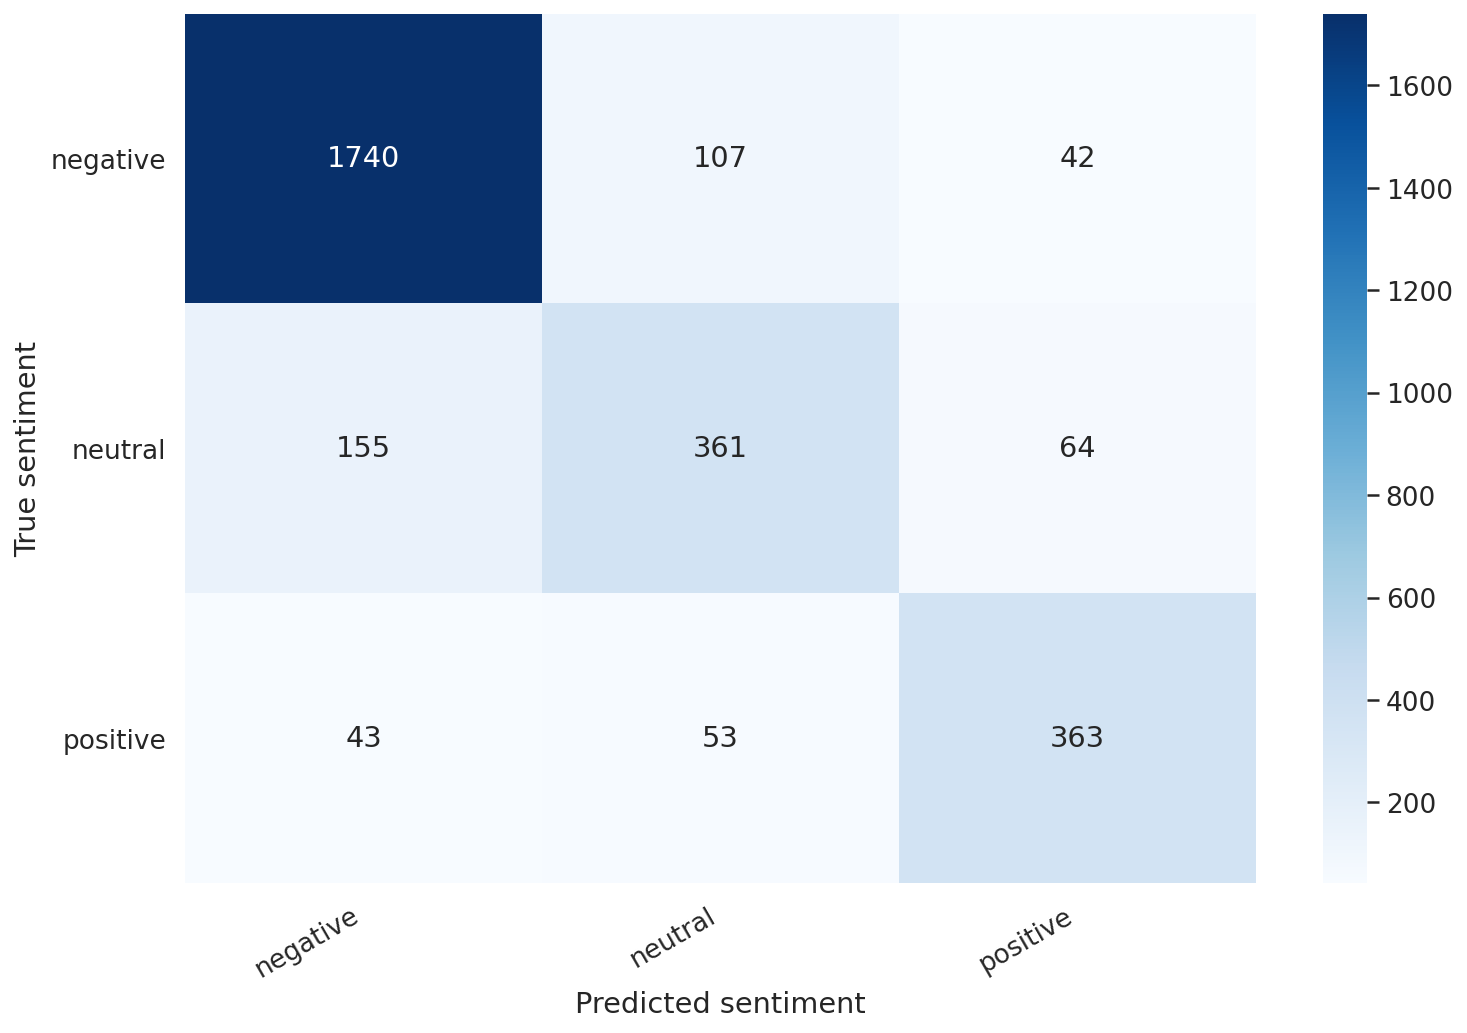

In [47]:
def show_confusion_matrix(confusion_matrix):
  hmap = sns.heatmap(confusion_matrix, annot=True, fmt="d", cmap="Blues")
  hmap.yaxis.set_ticklabels(hmap.yaxis.get_ticklabels(), rotation=0, ha='right')
  hmap.xaxis.set_ticklabels(hmap.xaxis.get_ticklabels(), rotation=30, ha='right')
  plt.ylabel('True sentiment')
  plt.xlabel('Predicted sentiment');

cm = confusion_matrix(y_test, y_pred)
df_cm = pd.DataFrame(cm, index=class_names, columns=class_names)
show_confusion_matrix(df_cm)

This confirms that our model is having difficulty classifying neutral reviews. It mistakes those for negative with more frequency than the positive.

That's a good overview of the performance of our model. But let's have a look at an example from our test data:

In [48]:
# This number can be changed to have more data to test qualitatively with
idx = 999

review_text = y_review_texts[idx]
true_sentiment = y_test[idx]
pred_df = pd.DataFrame({
  'class_names': class_names,
  'values': y_pred_probs[idx]
})

In [49]:
print("\n".join(wrap(review_text)))
print()
print(f'True sentiment: {class_names[true_sentiment]}')

bag in possession but no clothes in bag??

True sentiment: negative


Now we can look at the confidence of each sentiment of our model:

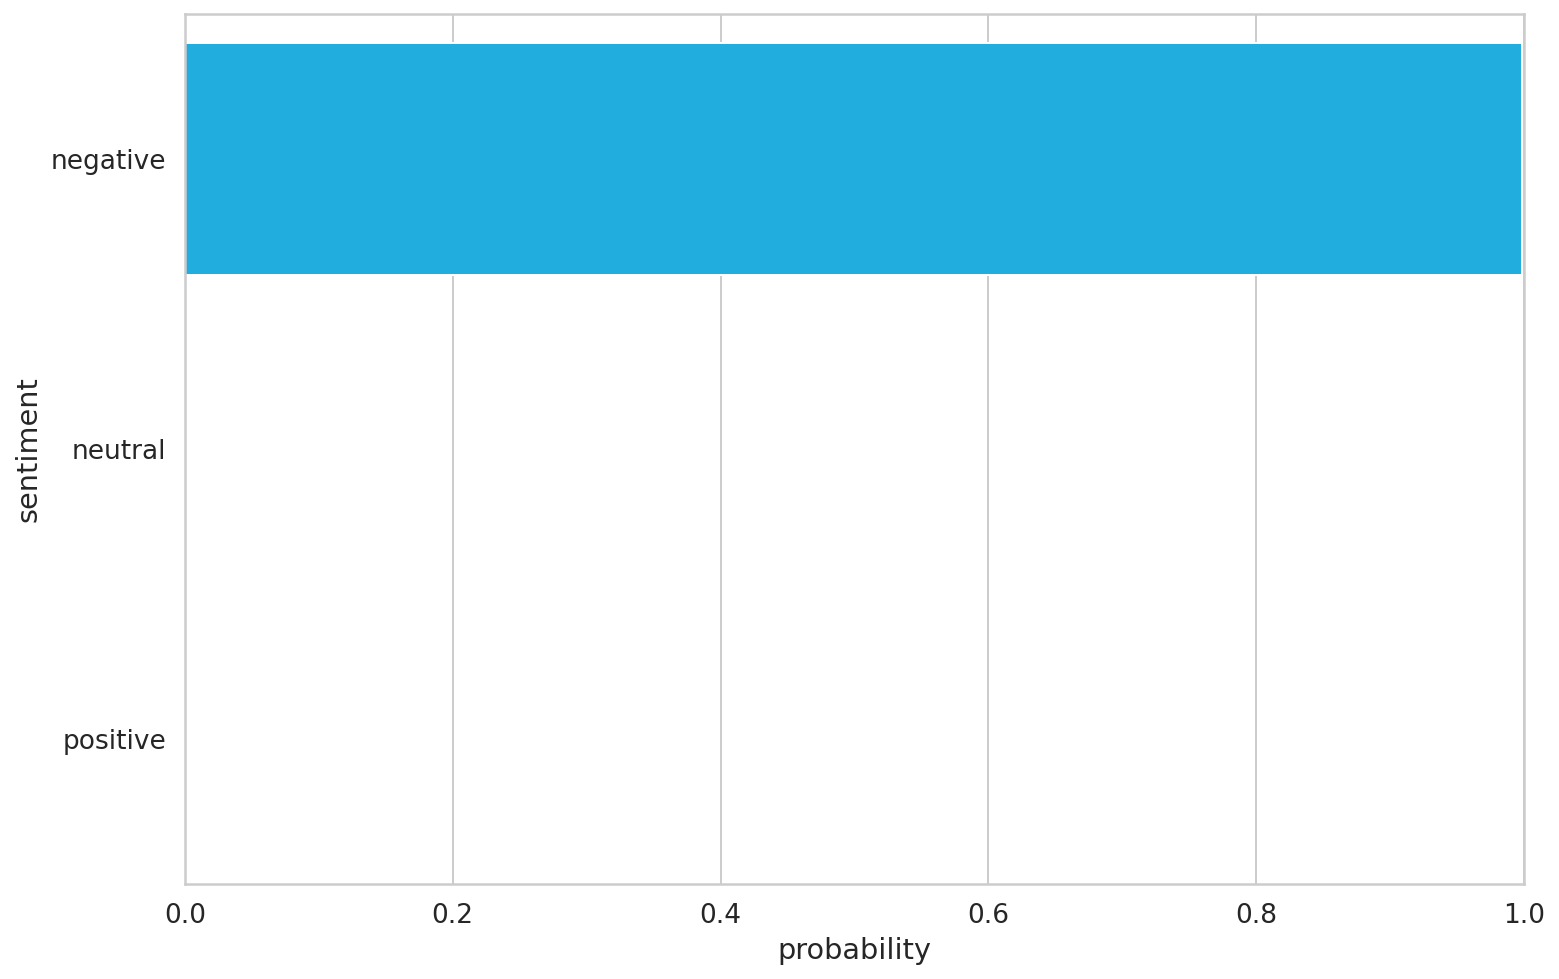

In [50]:
sns.barplot(x='values', y='class_names', data=pred_df, orient='h')
plt.ylabel('sentiment')
plt.xlabel('probability')
plt.xlim([0, 1]);

#### 2 - LSTM recurrent model

In [49]:
features_words = tweets['review']

# Get dummies values of the three classes, meaning one 3 dimensional vector of interger values for each line
labels = pd.get_dummies(df['airline_sentiment']).values

In [51]:
# Max features determine the max number of words in the entire dataset you will consider relevant
max_features = 500

# Create a tokenizer object and pass the max features to it
tokenizer = Tokenizer(num_words=max_features, split=' ')

# Call the tokenizer method fit_on_texts and fit the values of your features to it
tokenizer.fit_on_texts(features_words.values)

In [52]:
# Convert each line of text to sequences of integer values where each value correspond to one of the 100 max features
features = tokenizer.texts_to_sequences(features_words.values)

# Pad sequences is needed to homogenize the size of each line vector (if 100 max_features, then each line vector will be converted to 25dim vectors, blank or no words
# will be filled with zero value
features = pad_sequences(features)

In [55]:
features = pd.DataFrame(features)
labels = pd.DataFrame(labels)
labels = labels.rename(columns={0: "label_0", 1: "label_1", 2: "label_2"})
merged_features = features.merge(labels, left_index=True, right_index=True)

In [60]:
# Splitting the test data 
merged_features_temp,merged_features_test = train_test_split(merged_features,test_size=0.2, random_state=RANDOM_SEED)

# Splitting the training and validation data
merged_features_train, merged_features_val = train_test_split(merged_features_temp, test_size=0.1, random_state=RANDOM_SEED)

In [62]:
label_train = merged_features_train[['label_0','label_1','label_2']]
features_train = merged_features_train.drop(['label_0','label_1','label_2'], axis=1)
label_train = label_train.rename(columns={ "label_0":0, "label_1":1, "label_2":2})

label_val = merged_features_val[['label_0','label_1','label_2']]
features_val = merged_features_val.drop(['label_0','label_1','label_2'], axis=1)
label_val= label_val.rename(columns={ "label_0":0, "label_1":1, "label_2":2})

label_test = merged_features_test[['label_0','label_1','label_2']]
features_test = merged_features_test.drop(['label_0','label_1','label_2'], axis=1)
label_test = label_test.rename(columns={ "label_0":0, "label_1":1, "label_2":2})


In [65]:
input_len = features.shape[1]
embeding_dimension = 50
lstm_size = 70

In [222]:
# We create the model graph that would return the model instance
def lstm_model(input_shape):

    X_input = Input(shape = input_shape)
    X = Embedding(max_features,embeding_dimension, input_length=input_len)(X_input)
    X = SpatialDropout1D(0.2)(X)
    X = LSTM(lstm_size, dropout=0.2, recurrent_dropout=0.2)(X)

    X = Dense(3,activation='softmax')(X)

    model = Model(inputs = X_input, outputs = X)
    
    return model

In [261]:
lstm_model = lstm_model(input_shape = input_len)
lstm_model.summary()

Model: "functional_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 29)]              0         
_________________________________________________________________
embedding_1 (Embedding)      (None, 29, 50)            25000     
_________________________________________________________________
spatial_dropout1d_1 (Spatial (None, 29, 50)            0         
_________________________________________________________________
lstm_1 (LSTM)                (None, 70)                33880     
_________________________________________________________________
dense_1 (Dense)              (None, 3)                 213       
Total params: 59,093
Trainable params: 59,093
Non-trainable params: 0
_________________________________________________________________


In [229]:
opt = Adam(lr=0.00001)

lstm_model.compile(loss='categorical_crossentropy', optimizer=opt, metrics=["accuracy"])

In [230]:
filepath='best_accuracy.h5'

checkpoint = ModelCheckpoint(filepath,monitor='val_accuracy',mode='max',save_best_only=True,verbose=1)
callbacks_list = [checkpoint]

In [232]:
history = lstm_model.fit(features_train, label_train, batch_size = 16, epochs=150,validation_data=(features_val, label_val),callbacks=checkpoint)

Epoch 1/150
53/53 [==============================] - ETA: 0s - loss: 1.0764 - accuracy: 0.6225
Epoch 00001: val_accuracy improved from -inf to 0.62287, saving model to temp_bestmodel.h5
53/53 [==============================] - 7s 141ms/step - loss: 1.0764 - accuracy: 0.6225 - val_loss: 1.0758 - val_accuracy: 0.6229
Epoch 2/150
53/53 [==============================] - ETA: 0s - loss: 1.0756 - accuracy: 0.6225
Epoch 00002: val_accuracy did not improve from 0.62287
53/53 [==============================] - 7s 133ms/step - loss: 1.0756 - accuracy: 0.6225 - val_loss: 1.0751 - val_accuracy: 0.6229
Epoch 3/150
53/53 [==============================] - ETA: 0s - loss: 1.0751 - accuracy: 0.6226
Epoch 00003: val_accuracy did not improve from 0.62287
53/53 [==============================] - 7s 126ms/step - loss: 1.0751 - accuracy: 0.6226 - val_loss: 1.0745 - val_accuracy: 0.6229
Epoch 4/150
53/53 [==============================] - ETA: 0s - loss: 1.0745 - accuracy: 0.6223
Epoch 00004: val_accuracy 

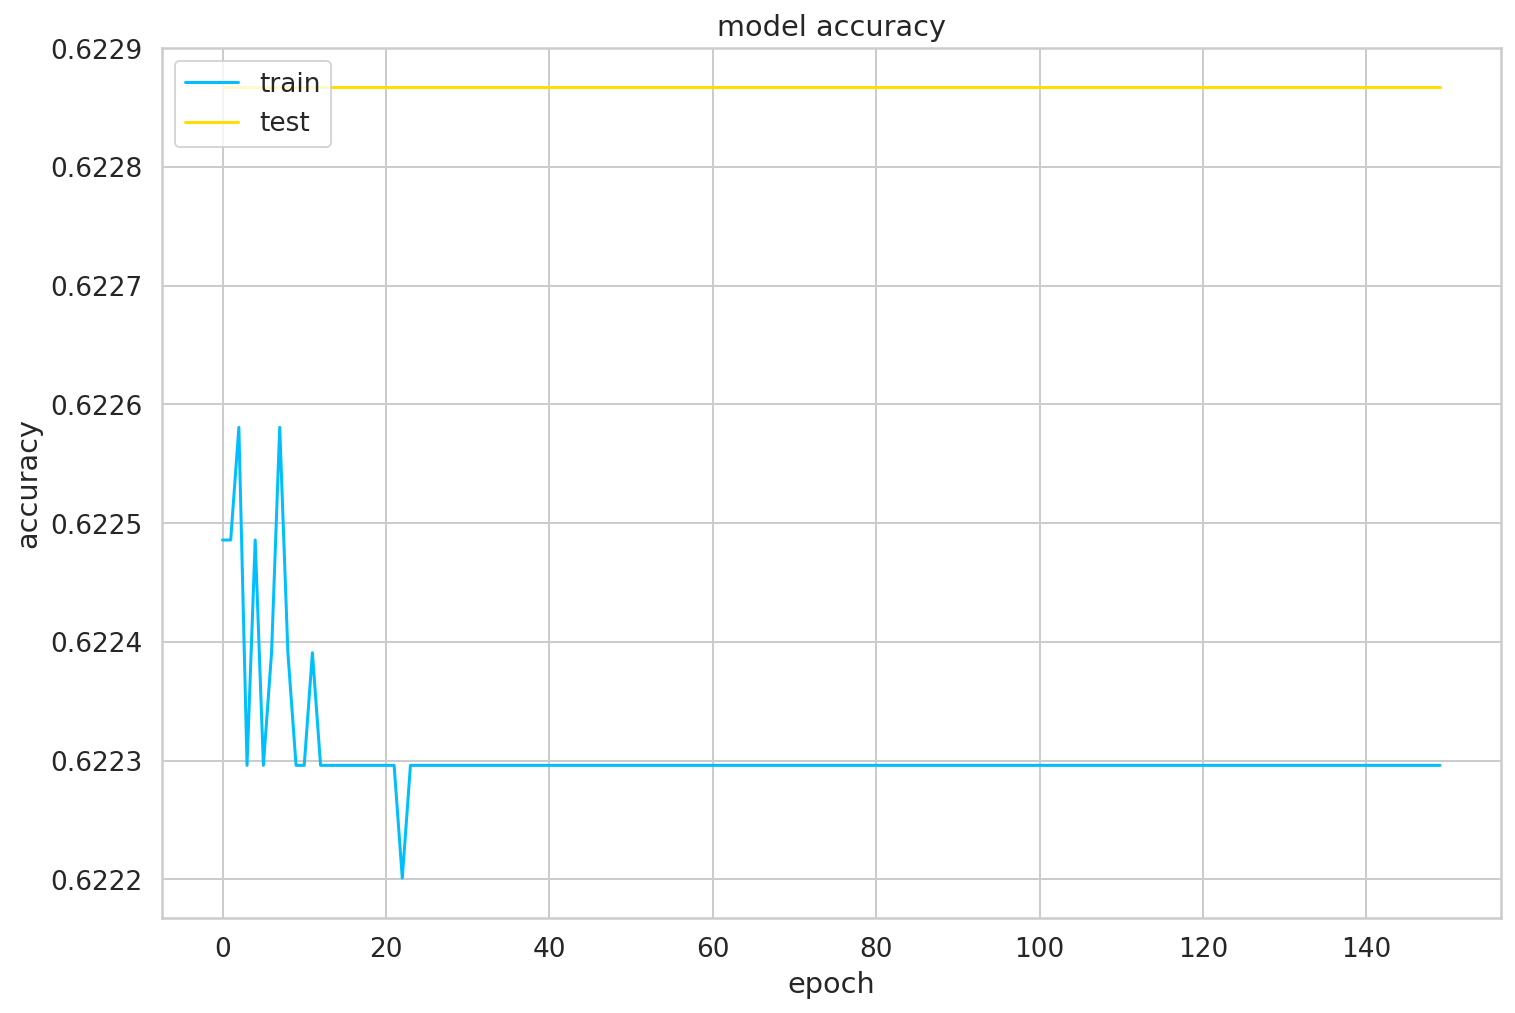

In [235]:
# summarize history for accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()



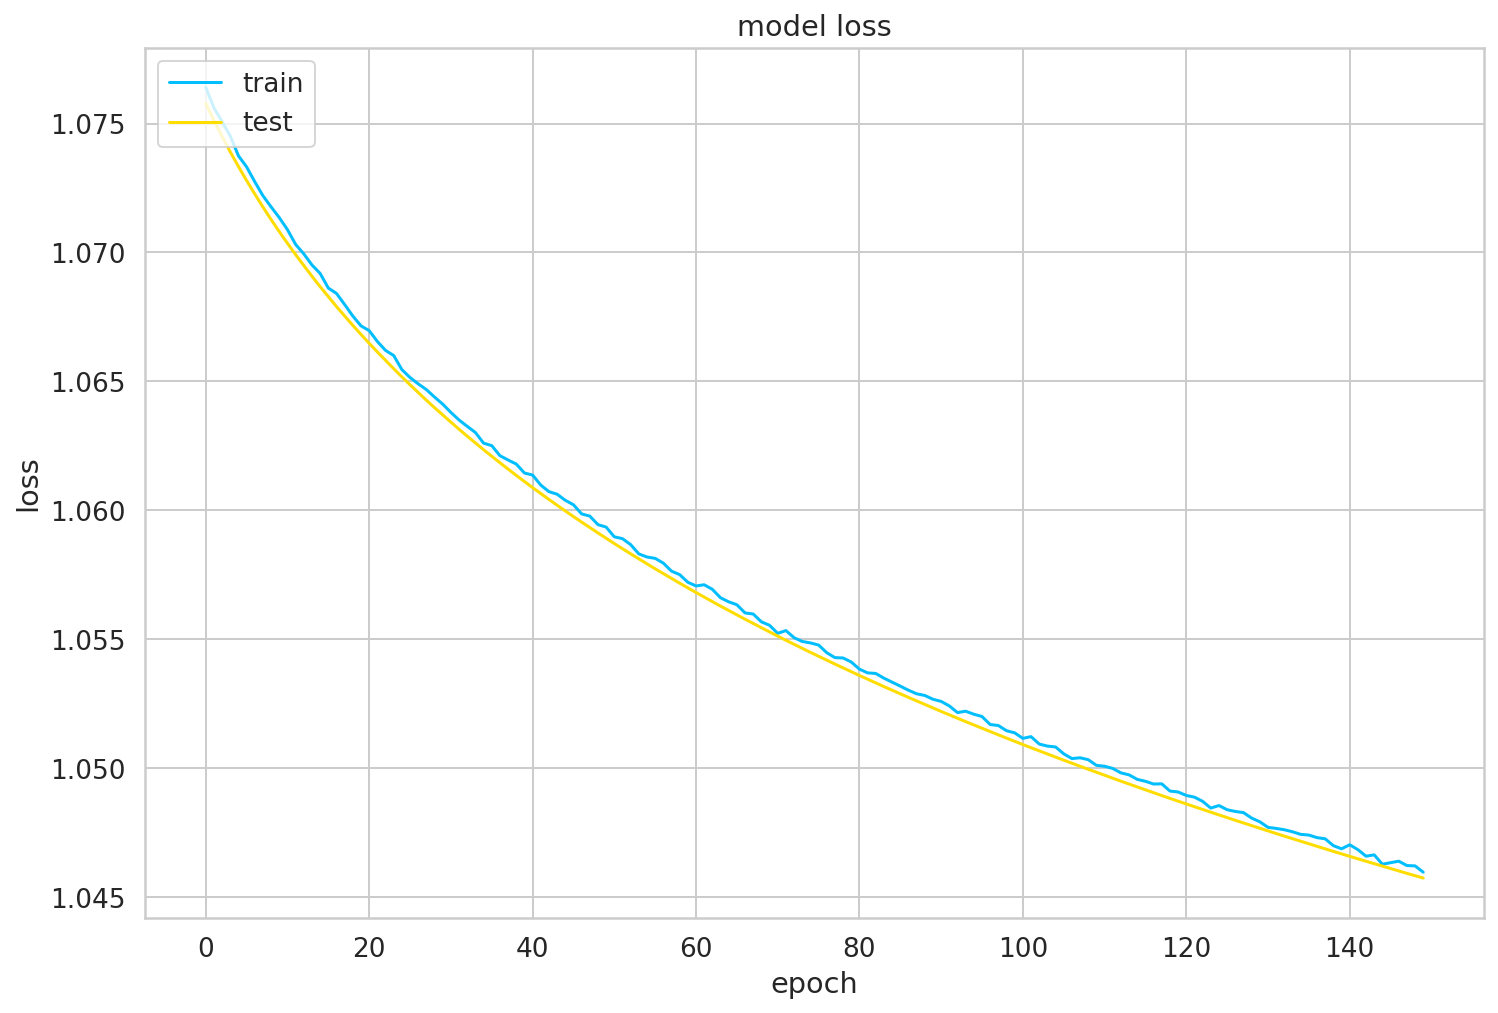

In [236]:
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [238]:
# Loading the best model
lstm_model = load_model("./best_accuracy.h5")

In [240]:
lstm_model.evaluate(features_test, label_test)

92/92 [==============================] - 1s 10ms/step - loss: 1.0741 - accuracy: 0.6452


[1.0741008520126343, 0.6451502442359924]

In [255]:
labels_pred = np.argmax(lstm_model.predict(features_test), axis=1).tolist()

In [256]:
label_ground_truth = []
for index, row in label_test.iterrows():
  if row[0] == 1:
    value = 0
  elif row[1] == 1:
    value = 1
  else :
    value = 2
  label_ground_truth.append(value)

In [257]:
print(classification_report(label_ground_truth, labels_pred, target_names=class_names))

              precision    recall  f1-score   support

    negative       0.65      1.00      0.78      1889
     neutral       0.00      0.00      0.00       580
    positive       0.00      0.00      0.00       459

    accuracy                           0.65      2928
   macro avg       0.22      0.33      0.26      2928
weighted avg       0.42      0.65      0.51      2928



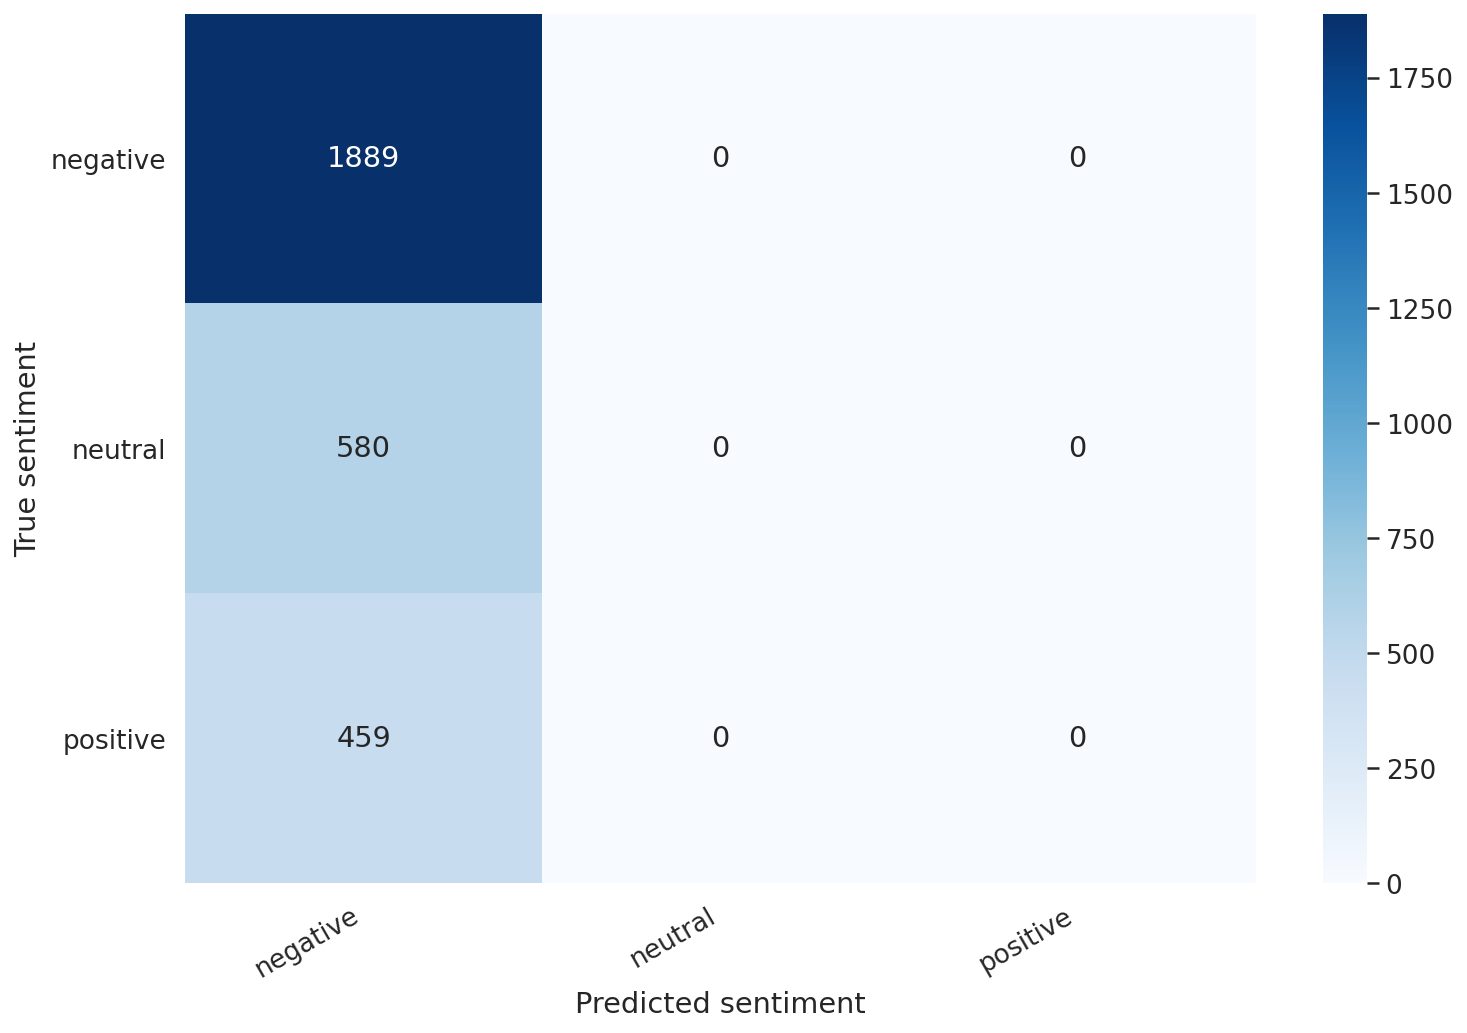

In [259]:
def show_confusion_matrix(confusion_matrix):
  hmap = sns.heatmap(confusion_matrix, annot=True, fmt="d", cmap="Blues")
  hmap.yaxis.set_ticklabels(hmap.yaxis.get_ticklabels(), rotation=0, ha='right')
  hmap.xaxis.set_ticklabels(hmap.xaxis.get_ticklabels(), rotation=30, ha='right')
  plt.ylabel('True sentiment')
  plt.xlabel('Predicted sentiment');

cm = confusion_matrix(label_ground_truth, labels_pred)
df_cm = pd.DataFrame(cm, index=class_names, columns=class_names)
show_confusion_matrix(df_cm)

#### 3 - Baseline method : Textblob